In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import plotly.express as px # type: ignore
from sklearn.decomposition import PCA

sns.set_theme(rc={'figure.figsize':(5,3)})

## data_cleaning

In [9]:
OAS_BLOOM = pd.read_csv("e://ehz/data/mbs_oas.csv", index_col=0, parse_dates=True)
OAS_BLOOM.columns = [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 1.5, 2, 7]
ALL_CPNS = np.arange(1.5, 7.5, 0.5)
OAS_BLOOM = OAS_BLOOM[ALL_CPNS]
OAS_BLOOM.to_csv("Data/OAS_vs_TREAS.csv")

In [10]:
TBAS_PRICES = pd.read_csv("e://ehz/data/mbs.csv", index_col=0, parse_dates=True).dropna(how="all")

In [15]:
TBAS_PRICES = pd.read_csv("e://ehz/data/mbs.csv", index_col=0, parse_dates=True).dropna(how="all")
d1 = pd.to_datetime('01/22/2021')
TBAS_PRICES.loc[: d1, 'FNCL 2.0 N Mtge'] = np.nan
TBAS_PRICES.to_csv("Data/GENERIC_TBAS.csv")

## data viz

In [17]:
OAS_BLOOM = pd.read_csv("Data/OAS_vs_TREAS.csv", index_col=0, parse_dates=True)
OAS_BLOOM.columns = OAS_BLOOM.columns.map(float)

TBAS_PRICES = pd.read_csv("Data/GENERIC_TBAS.csv", index_col=0, parse_dates=True).dropna(how="all")
TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: float(x.split()[1]))

In [35]:
x = 1

2.0


<Axes: >

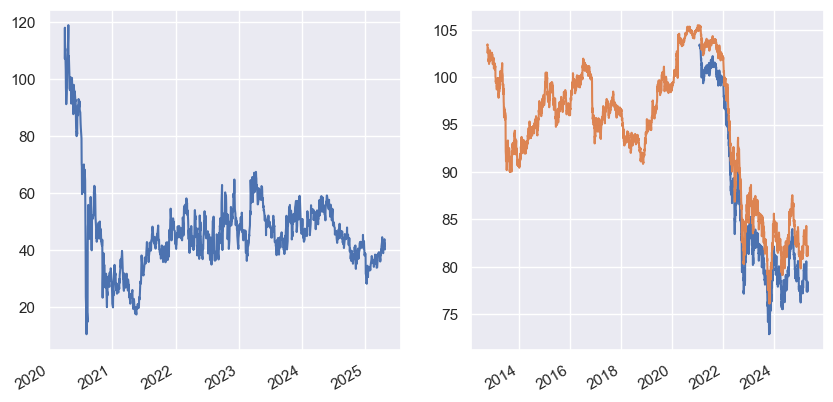

In [37]:
x = x+0.5
print(x)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
OAS_BLOOM[x].plot(ax=ax1)
TBAS_PRICES[x].plot(ax=ax2)
TBAS_PRICES[x+0.5].plot(ax=ax2)

In [ ]:
dic = {
    2: 'wrong prices even though oas exists. manually corrected',
    6: 'correct prices, wrong oas constant in 2018-2023',
    6.5: 'correct prices missing oas',
    7: 'empty oas untill sep 2023; wrong prices 2013-2023',
    7.5 : 'same as 7, no oas'
}

# conclusion : work with 2 -> 6.5 included

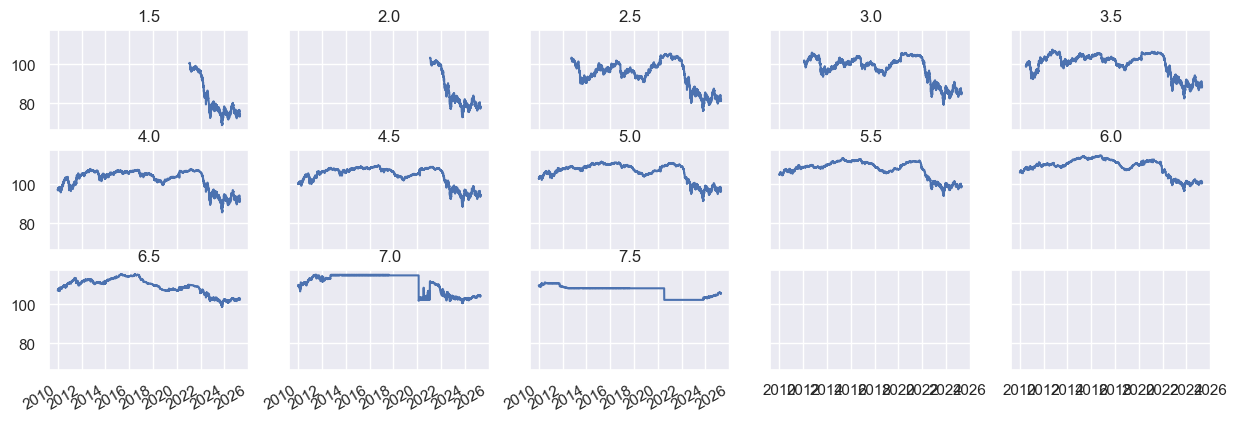

In [43]:
cpn_list = np.arange(1.5,8, 0.5)
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15,5), sharex=True, sharey=True)
axs = axs.flatten()
for i, c in enumerate(cpn_list):
    ax = axs[i]
    #(rolled_tba[c]).plot(ax=ax)
    TBAS_PRICES[c].plot(ax=ax)
    ax.set_title(f'{c}')

In [44]:
cpn_list = np.arange(1.5,7, 0.5)

## backtest

In [51]:
def get_data(sub_folder, ALL_CPNS, oas_bloom_filter=False):


    OAS = pd.read_csv(f'Data/{sub_folder}/OAS.csv', index_col=0, parse_dates=True, dayfirst=False)
    OAS.columns = OAS.columns.map(float)
    OAS = OAS[ALL_CPNS]

    if oas_bloom_filter :

        OAS_BLOOM = pd.read_csv("Data/OAS_vs_TREAS.csv", index_col=0, parse_dates=True)
        OAS_BLOOM.columns = OAS_BLOOM.columns.map(float)
        OAS_BLOOM = OAS_BLOOM[ALL_CPNS]

        OAS = OAS.where(OAS_BLOOM.notna())
        OAS.dropna(how='all', inplace=True)
    

    TBAS_PRICES = pd.read_csv("Data/GENERIC_TBAS.csv", index_col=0, parse_dates=True).dropna(how="all")
    TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: float(x.split()[1]))
    TBAS_PRICES = TBAS_PRICES[ALL_CPNS]
    TBAS_PRICES = TBAS_PRICES.loc[OAS.index]

    Durations = pd.read_csv(f'Data/{sub_folder}/Durations.csv', index_col=0, parse_dates=True)
    Durations.columns = Durations.columns.map(float) 
    Durations = Durations[ALL_CPNS]
    Durations = Durations.loc[OAS.index]

    return TBAS_PRICES, OAS, Durations


def assign_weights(x, durations = None, equiweights = True, epsilon=0.3, holding_period=0):
    """
    """

    weights = pd.Series(0.0, index=x.index)
    
    # Get the indices of the three highest OAS
    three_highest = x.nlargest(3).index
    # Get the index of the lowest OAS
    lowest = x.idxmin()
    three_lowest = x.nsmallest(3).index

    # Compute the adjusted weight for the lowest OAS
    if  not equiweights : 
        weights[three_highest] = 1/3/durations[three_highest]
        weights[lowest] = -1/durations[lowest]

    else : 

        # Assign 1/3 to the three highest OAS
        weights[three_highest] = np.array([1/3, 1/3, 1/3])
        #weights[lowest] =  -1 #-durations[three_highest].dot(weights[three_highest])/ durations[lowest]
        weights[three_lowest] = -np.array([1/3, 1/3, 1/3])
    return weights



# Global variables to store previous rankings
prev_top3 = None
prev_bottom3 = None
hold_counter = None  

def assign_weights_(x, durations = None, equiweights = True, epsilon=0.3, holding_period=0):
    """
    Assigns weights to securities based on OAS residuals, while reducing unnecessary trades.

    - Uses `epsilon` to avoid ranking changes when OAS differences are small.
    - Enforces a minimum holding period (`holding_period`).
    - Reduces transaction costs by avoiding rebalancing due to small shifts.

    Parameters:
    - x: pd.Series, OAS residuals for each security.
    - epsilon: float, threshold for ignoring small OAS ranking changes.
    - holding_period: int, minimum number of periods to hold an asset before rebalancing.

    Returns:
    - pd.Series, updated weights.
    """
    global prev_top3, prev_bottom3, hold_counter  

    # Initialize weights to zero
    weights = pd.Series(0.0, index=x.index)

    # Sort OAS residuals
    sorted_x = x.sort_values(ascending=False)
    
    # Identify top 3 (cheapest) and bottom 3 (most expensive)
    top3 = sorted_x.index[:3]
    bottom3 = sorted_x.index[-3:]

    # If first run, initialize previous rankings and holding counter
    if prev_top3 is None or prev_bottom3 is None:
        prev_top3, prev_bottom3 = top3, bottom3
        hold_counter = pd.Series(0, index=x.index)
        weights[top3] = 1/3
        weights[bottom3] = -1/3
        return weights

    # Check if ranking changes are significant
    ranking_changed = False

    for asset in top3:
        if asset not in prev_top3:
            # Check if its OAS is significantly different from the previous third-ranked asset
            if abs(x[asset] - x[prev_top3[-1]]) > epsilon:
                ranking_changed = True

    for asset in bottom3:
        if asset not in prev_bottom3:
            # Check if its OAS is significantly different from the previous third-ranked asset
            if abs(x[asset] - x[prev_bottom3[-1]]) > epsilon:
                ranking_changed = True

    # Enforce holding period: Only allow changes if ranking has changed significantly
    if ranking_changed:
        for asset in x.index:
            if hold_counter[asset] < holding_period:
                weights[asset] = 0  # Maintain previous position if within holding period
                hold_counter[asset] += 1
            else:
                weights[top3] = 1/3
                weights[bottom3] = -1/3
                hold_counter[asset] = 0  # Reset hold counter if rebalanced
    else:
        # Keep previous weights if no significant ranking change
        weights[prev_top3] = 1/3
        weights[prev_bottom3] = -1/3

    # Update previous rankings for next period
    prev_top3, prev_bottom3 = top3, bottom3

    return weights



def get_acp_res_oas_1(OAS_df, n_components,
                    training_window = 200, prediction_window =20, standardize=True):
    OAS_mean = OAS_df.mean()
    OAS_std = OAS_df.std()
    OAS_normalized = (OAS_df - OAS_mean) / OAS_std
    OAS_normalized = OAS_df
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(OAS_normalized)

    # Create DataFrame for PCA components
    pca_components = pd.DataFrame(pca_transformed, index=OAS_df.index, columns=[f"PCA_{i+1}" for i in range(n_components)])

    oas_pca = pca.inverse_transform(pca_components)
    oas_pca.columns = (OAS_df.columns)
    #oas_pca = oas_pca*OAS_std + OAS_mean
    RES_OAS = (OAS_df - oas_pca)
    RES_OAS = RES_OAS.where(OAS_df.notna())
    return RES_OAS


def get_acp_res_oas_2(data, n_components,
                    training_window = 200, prediction_window =20, standardize=True):
    """
    Compute rolling PCA residual OAS (RES_OAS) on the given dataset with optional standardization.
    
    PCA is fit on a rolling training window (of length `training_window`) and then applied to the 
    subsequent `prediction_window` to compute out-of-sample residuals. After each prediction window, 
    the training window slides forward by the length of the prediction window (no future data is used 
    in any PCA fit).

    Parameters:
    - data: pd.DataFrame, the input dataset (indexed by time, columns are features/OAS series).
    - training_window: int, number of periods in each PCA training window (e.g., 252 trading days for 1 year).
    - prediction_window: int, number of periods in each prediction window (e.g., 21 trading days for 1 month).
    - standardize: bool, whether to standardize data (Z-score normalization) before applying PCA.
    
    Returns:
    - pd.DataFrame containing the aggregated residuals (RES_OAS) for each prediction window, indexed by time.
      The residuals DataFrame has no values for the initial training period (since those points were used for 
      training and not for out-of-sample prediction).
    """
    residuals_list = []  # To store residuals from each prediction window

    n = len(data)
    for train_start in range(0, n - training_window - prediction_window + 1, prediction_window):
        # Define training & prediction windows
        train_end = train_start + training_window
        pred_end = train_end + prediction_window
        
        train_data = data.iloc[train_start:train_end]
        pred_data  = data.iloc[train_end:pred_end]

        # Standardization (if enabled)
        if standardize:
            mean_train = train_data.mean()
            std_train = train_data.std().replace(0, 1)  # Avoid division by zero
            train_data_std = (train_data - mean_train) / std_train
            pred_data_std  = (pred_data - mean_train) / std_train  # Apply same mean/std to prediction window
        else:
            train_data_std = train_data
            pred_data_std  = pred_data

        # Fit PCA on training window
        pca = PCA(n_components=n_components)
        pca.fit(train_data_std)

        # Transform & reconstruct prediction data
        pred_scores = pca.transform(pred_data_std)
        pred_reconstructed = pca.inverse_transform(pred_scores)

        pred_reconstructed = pd.DataFrame(pred_reconstructed, index=pred_data.index, columns=data.columns)

        # Denormalize PCA-reconstructed data if standardization was applied
        if standardize:
            pred_reconstructed = (pred_reconstructed * std_train) + mean_train

        # Compute residuals (actual - reconstructed)
        res_df = pred_data - pred_reconstructed

        residuals_list.append(res_df)

    # Concatenate all residuals across time
    residuals_all = pd.concat(residuals_list)
    return residuals_all


def get_acp_res_oas_3(data, n_components,
                    training_window = 200, prediction_window =20, standardize=True):
    """
    Compute rolling PCA residual OAS (RES_OAS) on the given dataset with an expanding window approach.

    PCA is initially fit on `training_window` length data, but after each `prediction_window`, the 
    training data expands to include all past data (never forgetting previous values).

    Parameters:
    - data: pd.DataFrame, the input dataset (indexed by time, columns are features/OAS series).
    - training_window: int, number of periods in the initial PCA training window (e.g., 252 trading days for 1 year).
    - prediction_window: int, number of periods in each prediction window (e.g., 21 trading days for 1 month).
    - standardize: bool, whether to standardize data (Z-score normalization) before applying PCA.
    - n_components: int, number of PCA components to use.
    
    Returns:
    - pd.DataFrame containing the aggregated residuals (RES_OAS) for each prediction window, indexed by time.
      The residuals DataFrame has no values for the initial training period (since those points were used for 
      training and not for out-of-sample prediction).
    """
    residuals_list = []  # Store residuals
    n = len(data)

    # Start with the initial training window
    train_end = training_window

    while train_end + prediction_window <= n:
        pred_end = train_end + prediction_window
        
        # Expanding window: Train on all past data up to `train_end`
        train_data = data.iloc[:train_end]
        pred_data  = data.iloc[train_end:pred_end]

        # Standardization (if enabled)
        if standardize:
            mean_train = train_data.mean()
            std_train = train_data.std().replace(0, 1)  # Avoid division by zero
            train_data_std = (train_data - mean_train) / std_train
            pred_data_std  = (pred_data - mean_train) / std_train  # Apply same mean/std to prediction window
        else:
            train_data_std = train_data
            pred_data_std  = pred_data

        # Fit PCA on all past data (expanding window)
        pca = PCA(n_components=n_components)
        pca.fit(train_data_std)

        # Transform & reconstruct prediction data
        pred_scores = pca.transform(pred_data_std)
        pred_reconstructed = pca.inverse_transform(pred_scores)

        # Convert to DataFrame for alignment
        pred_reconstructed = pd.DataFrame(pred_reconstructed, index=pred_data.index, columns=data.columns)

        # Denormalize if standardization was applied
        if standardize:
            pred_reconstructed = (pred_reconstructed * std_train) + mean_train

        # Compute residuals (actual - reconstructed)
        res_df = pred_data - pred_reconstructed

        residuals_list.append(res_df)

        # Expand the training window
        train_end += prediction_window

    # Concatenate all residuals across time
    residuals_all = pd.concat(residuals_list)
    return residuals_all

mr_methods = [lambda x: x, get_acp_res_oas_1, get_acp_res_oas_2, get_acp_res_oas_3]

def compute_backtest(
        model, ALL_CPNS, lissage, bid_to_mid, equiweights, MR , n_components=1,   
        verbose = True, oas_bloom_filter = False, training_window=200, prediction_window = 20,
        standardize = True
        ):
    
    
    
    TBAS_PRICES, OAS, Durations = get_data(model, ALL_CPNS, oas_bloom_filter)

    # Apply assign_weights along the rows (axis=1) of the OAS DataFrame or the RES_oas 
    signal = OAS
    if MR >0 :
        OAS = OAS.dropna()
        method = mr_methods[MR]
        signal = method(OAS, n_components,
                        training_window=training_window, 
                        prediction_window=prediction_window,
                        standardize=standardize,
                        ) 
        #signal = get_acp_res_oas(OAS,n_components) 

    #W = signal.apply(lambda row: assign_weights(row, Durations.loc[row.name], equiweights), axis=1)
    W = pd.DataFrame(0.0, index=signal.index, columns=signal.columns)  # Initialize weights DataFrame

    for i in range(len(signal)):
        W.iloc[i] = assign_weights(signal.iloc[i], Durations.iloc[i], equiweights)  # Apply the function row-by-row

    

    TBAS_PRICES = TBAS_PRICES.loc[W.index]

    # Smooth the weights using a rolling average over the past 10 days
    W_smoothed = W.rolling(window=lissage, min_periods=lissage).mean()
    # Calculate daily P&L of the strategy
    PnL = (TBAS_PRICES.diff() * W_smoothed.shift(1)).sum(axis=1)
    # Calculate transaction costs due to changes in weights
    weight_changes = W_smoothed.diff().abs()  # Absolute changes in smoothed weights
    transaction_costs = (weight_changes * bid_to_mid).sum(axis=1)
    # Adjust P&L for transaction costs
    PnL_net = PnL - transaction_costs

    if verbose : 

        sharpe_ratio = PnL.mean() / PnL.std() * np.sqrt(252)  # Annualized
        sharpe_pnl_net = PnL_net.mean() / PnL_net.std() * np.sqrt(252)
        yearly_pnl = PnL_net.groupby(PnL_net.index.map(lambda x:x.year)).sum().mean()
        yearly_vol = PnL_net.groupby(PnL_net.index.map(lambda x:x.year)).sum().std()

        # Display results
        performance_df = pd.DataFrame({
            "Sharpe Ratio": [sharpe_ratio],
            "Sharpe Ratio net": [sharpe_pnl_net],
            "Avg Yearly PnL": [yearly_pnl],
            "Yearly Volatility": [yearly_vol]
            
        })
        display(performance_df)
        PnL_cumsum = PnL.cumsum()
        PnL_net_cumsum = PnL_net.cumsum()



        fig = px.line(
            pd.DataFrame({"PnL": PnL_cumsum, "PnL_net": PnL_net_cumsum}),
            title="Cumulative P&L vs Net P&L",
            labels={"value": "Cumulative P&L", "index": "Date"}
        )
        fig.update_layout(xaxis_title="Date", yaxis_title="Cumulative P&L")
        fig.show()
        return PnL_net

    else : 
        sharpe_pnl_net = PnL_net.mean() / PnL_net.std() * np.sqrt(252)
        return sharpe_pnl_net

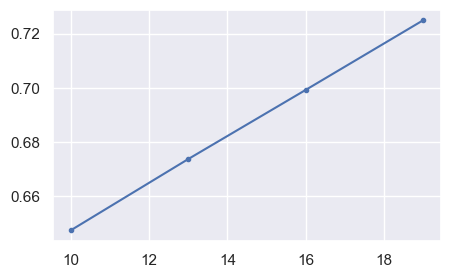

In [22]:
model = 'DATA_SAMY'
ALL_CPNS = np.arange(2, 7, 0.5)
bid_to_mid = 2/32
equiweights = True
MR = 0
n_components = None
verbose = False
oas_bloom_filter = False

lissages = np.arange(10,20, 3)

s1 = [compute_backtest(
        model, ALL_CPNS, lissage, bid_to_mid, equiweights, MR , 
        n_components, verbose, oas_bloom_filter) for lissage in lissages]

plt.plot(lissages, s1, marker='.')

In [23]:
lissage = 20
verbose = True
pnl_flat = compute_backtest(
      model, ALL_CPNS, lissage, bid_to_mid, equiweights, MR , 
        n_components, verbose, oas_bloom_filter)

,Sharpe Ratio,Sharpe Ratio net,Avg Yearly PnL,Yearly Volatility
0,0.887115,0.733529,2.274193,3.609986


## case analysis

In [16]:
model = 'DATA_SAMY'
ALL_CPNS = np.arange(2, 7, 0.5)
bid_to_mid = 1/32
equiweights = True
MR = 0
n_components = None
oas_bloom_filter = False
lissages = 20

In [17]:
TBAS_PRICES, OAS, Durations = get_data(model, ALL_CPNS, oas_bloom_filter)
signal = OAS
W = signal.apply(lambda row: assign_weights(row, Durations.loc[row.name], equiweights=True), axis=1) 
TBAS_PRICES = TBAS_PRICES.loc[signal.index]

# Smooth the weights using a rolling average over the past 10 days
W_smoothed = W.rolling(window=lissage, min_periods=lissage).mean()
# Calculate daily P&L of the strategy
PnL = (TBAS_PRICES.diff() * W_smoothed.shift(1)).sum(axis=1)
# Calculate transaction costs due to changes in weights
weight_changes = W_smoothed.diff().abs()  # Absolute changes in smoothed weights
transaction_costs = (weight_changes * bid_to_mid).sum(axis=1)
# Adjust P&L for transaction costs
PnL_net = PnL - transaction_costs

<Axes: xlabel='Dates'>

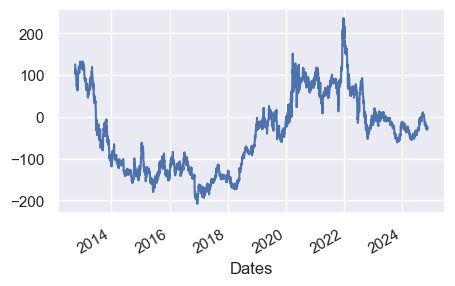

In [21]:
(OAS[6] - OAS[2.5]).plot()

<Axes: xlabel='Dates'>

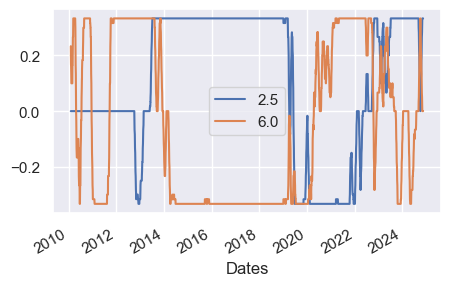

In [26]:
W_smoothed[[2.5, 6]].plot()

## read data

In [16]:
ALL_CPNS = np.arange(2, 7.5, 0.5)
ALL_CPNS_TBAS = np.arange(1.5, 8.0, 0.5)
df = pd.read_csv('Data/DATA_SAMY/oas_result_global_2010_2024_with_pnl.csv', index_col=0, parse_dates=True)

<Axes: xlabel='Dates'>

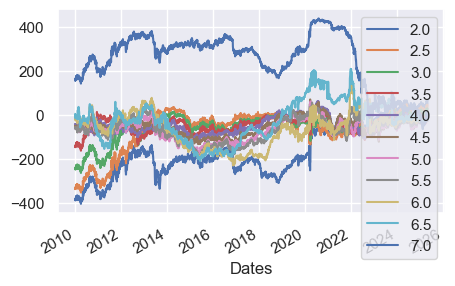

In [17]:
OAS = df[['OAS_0.020', 'OAS_0.025',
       'OAS_0.030', 'OAS_0.035', 'OAS_0.040', 'OAS_0.045', 'OAS_0.050',
       'OAS_0.055', 'OAS_0.060', 'OAS_0.065', 'OAS_0.070']]
OAS.columns = ALL_CPNS
OAS.plot()

<Axes: xlabel='Dates'>

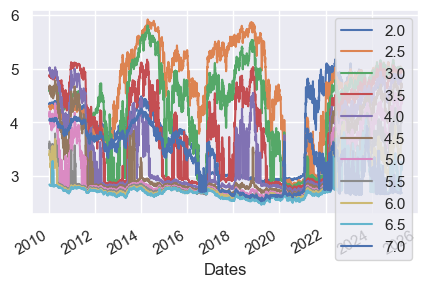

In [18]:
Durations = df[['Duration_0.020',
       'Duration_0.025', 'Duration_0.030', 'Duration_0.035', 'Duration_0.040',
       'Duration_0.045', 'Duration_0.050', 'Duration_0.055', 'Duration_0.060',
       'Duration_0.065', 'Duration_0.070']]
Durations.columns= ALL_CPNS
Durations.plot()

In [19]:
OAS.to_csv('Data/DATA_SAMY/OAS.csv')
Durations.to_csv(f"Data/DATA_SAMY/Durations.csv")

In [13]:
Durations

,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0
Dates,,,,,,,,,,,
2010-01-04,-0.000000,-0.000000,-0.000000,-0.000000,5.220305,5.429401,5.487760,1.485202,NaN,NaN,NaN
2010-01-05,-0.000000,-0.000000,-0.000000,-0.000000,5.275869,5.467729,5.439010,0.284816,NaN,NaN,NaN
2010-01-06,-0.000000,-0.000000,-0.000000,-0.000000,5.236747,5.436130,5.379758,NaN,NaN,NaN,NaN
2010-01-07,-0.000000,-0.000000,-0.000000,-0.000000,5.205479,5.414433,5.381303,NaN,NaN,NaN,NaN
2010-01-08,-0.000000,-0.000000,-0.000000,-0.000000,5.203145,5.410355,5.447604,0.828293,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-07,3.985999,4.291529,4.548921,4.827815,5.047994,5.214628,5.353704,5.458048,5.513089,5.446408,2.556475
2024-11-08,3.990443,4.274866,4.555236,4.831578,5.052222,5.224078,5.365583,5.469009,5.519188,5.424333,2.186459
2024-11-12,3.923155,4.196883,4.475602,4.749079,4.971293,5.156444,5.309610,5.422312,5.484953,5.462313,3.242126


In [14]:
sub_folder = 'DATA_SAMY'

In [ ]:
ALL_CPNS = np.arange(2.5, 7, 0.5)
ALL_CPNS_TBAS = np.arange(1.5, 8.0, 0.5)


OAS = pd.read_csv(f'Data/{sub_folder}/OAS.csv', index_col=0, parse_dates=True, dayfirst=False)
OAS.columns = ALL_CPNS

OAS_BLOOM = pd.read_csv("Data/OAS_vs_TREAS.csv", index_col=0)
OAS_BLOOM.index = pd.to_datetime(OAS_BLOOM.index, format="%Y-%m-%d")
#OAS_BLOOM = OAS_BLOOM.iloc[:, :9]
#OAS_BLOOM.columns = ALL_CPNS

#OAS = OAS.where(OAS_BLOOM.notna())
#OAS.dropna(how='all', inplace=True)



TBAS_PRICES = pd.read_csv("Data/GENERIC_TBAS.csv", index_col=0).dropna(how="all")
TBAS_PRICES.index = pd.to_datetime(TBAS_PRICES.index, format="%Y-%m-%d")
TBAS_PRICES.columns = ALL_CPNS_TBAS
TBAS_PRICES = TBAS_PRICES[ALL_CPNS]
TBAS_PRICES = TBAS_PRICES.loc[OAS.index]


Durations = pd.read_csv(f'Data/{sub_folder}/Durations.csv', index_col=0, parse_dates=True, dayfirst=False)
Durations.columns = ALL_CPNS
Durations = Durations.loc[OAS.index]

In [22]:
OAS = OAS[ALL_CPNS[1:-1]].dropna()
Durations = Durations[ALL_CPNS[1:-1]].loc[OAS.index]

## sanity checks

<Axes: >

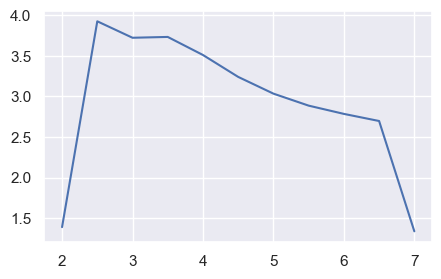

In [8]:
(Durations).mean(axis=0).plot()

In [169]:
stat_durations = TBAS_PRICES.diff().std()
hedge_ratios_stat = stat_durations/stat_durations.loc[4.5]
TBA_returns = TBAS_PRICES.diff().dropna()
TBA_returns_hedged = TBA_returns.apply(lambda x :  x/hedge_ratios_stat.loc[x.name])

<Axes: >

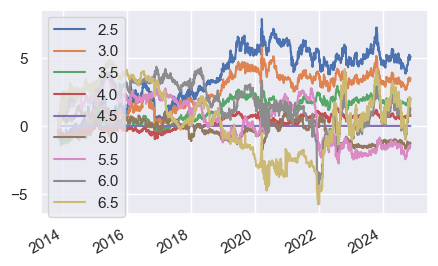

In [107]:
TBA_returns_hedged.apply(lambda x: x - TBA_returns_hedged[4.5]).cumsum().plot()

<Axes: >

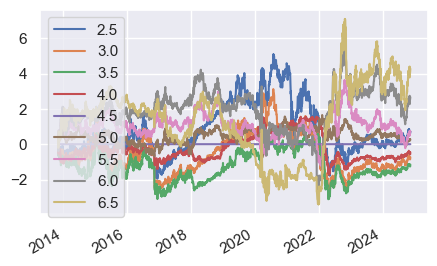

In [7]:
stat_durations = TBAS_PRICES.diff().std()
TBA_returns = TBAS_PRICES.diff().dropna()
TBA_returns_hedged = (TBA_returns/Durations.shift(1).dropna()).apply(lambda x: x*Durations.shift(1).dropna()[4.5])
TBA_returns_hedged.apply(lambda x: x - TBA_returns_hedged[4.5]).cumsum().plot()

## acp 

In [23]:
from sklearn.decomposition import PCA

# Example data: Randomly generated OAS values for 9 TBAs over 500 days
np.random.seed(42)


def perform_pca_analysis(OAS_df, n_components=1):
    """
    Perform PCA on the OAS data and plot results.

    Parameters:
    OAS_df : DataFrame
        DataFrame containing dates in index and 9 TBA OAS values in columns.
    n_components : int
        Number of principal components to extract.

    Returns:
    pca_components : DataFrame
        The transformed PCA components over time.
    """
    # Standardizing data by removing the mean
    OAS_mean = OAS_df.mean()
    OAS_std = OAS_df.std()
    OAS_normalized = (OAS_df - OAS_mean) / OAS_std

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(OAS_normalized)

    # Create DataFrame for PCA components
    pca_components = pd.DataFrame(pca_transformed, index=OAS_df.index, columns=[f"PCA_{i+1}" for i in range(n_components)])

    # Plot the top three eigenvectors
    plt.figure(figsize=(10, 5))
    for i in range(n_components):
        plt.plot(OAS_df.columns, pca.components_[i], label=f'PCA {i+1}_{round(pca.explained_variance_ratio_[i],2)}')
    plt.title("PCA Eigenvectors")
    plt.xlabel("Coupons")
    plt.ylabel("Eigenvector Loadings")
    plt.legend()
    plt.grid(True)
    plt.show()

    fig = px.line(pca_components, title = "PCA Components Over Time")

    return pca, pca_components,OAS_mean, OAS_std, fig


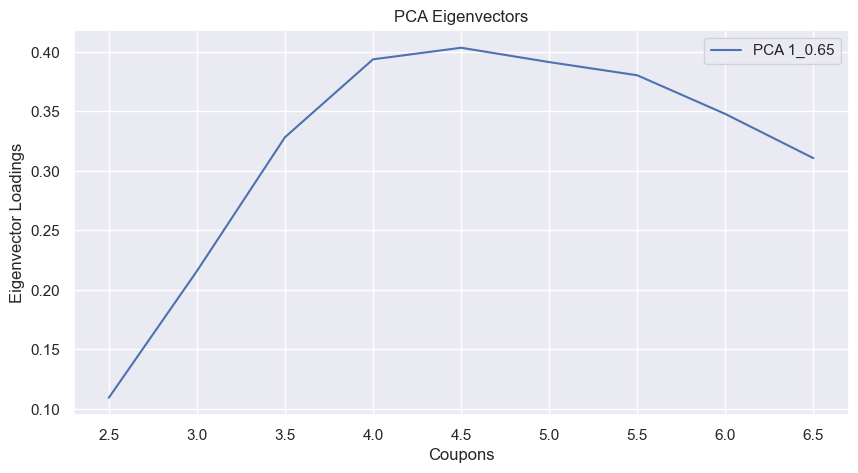

In [24]:
# Run PCA analysis on OAS data
OAS_df = OAS#.dropna()#ffill(axis=1).bfill(axis=1)
dates = OAS_df.index
pca, pca_components,OAS_mean, OAS_std, fig = perform_pca_analysis(OAS_df,1)

In [ ]:
oas_pca = pca.inverse_transform(pca_components)
oas_pca.columns = (OAS.columns)
oas_pca = oas_pca*OAS_std + OAS_mean
RES_OAS = (OAS_df - oas_pca)
RES_OAS = RES_OAS.where(OAS.notna())

## SAMY strat

In [55]:
lissage = 10
bid_offer = 1/32
equiweights = True
MR = False

In [56]:
# Apply assign_weights along the rows (axis=1) of the OAS DataFrame
W = OAS.apply(lambda row: assign_weights(row, Durations.loc[row.name]), axis=1)


# Smooth the weights using a rolling average over the past 10 days
W_smoothed = W.rolling(window=lissage, min_periods=lissage).mean()
# Calculate daily P&L of the strategy
PnL = (TBAS_PRICES.loc[OAS.index].diff() * W_smoothed.shift(1)).sum(axis=1)
# Calculate transaction costs due to changes in weights
weight_changes = W_smoothed.diff().abs()  # Absolute changes in smoothed weights
transaction_costs = (weight_changes * bid_offer).sum(axis=1)
# Adjust P&L for transaction costs
PnL_net = PnL - transaction_costs
sharpe_ratio = PnL.mean() / PnL.std() * np.sqrt(252)  # Annualized
sharpe_pnl_net = PnL_net.mean() / PnL_net.std() * np.sqrt(252)
yearly_pnl = PnL_net.groupby(PnL_net.index.map(lambda x:x.year)).sum().mean()
yearly_vol = PnL_net.groupby(PnL_net.index.map(lambda x:x.year)).sum().std()

# Display results
performance_df = pd.DataFrame({
    "Sharpe Ratio": [sharpe_ratio],
    "Sharpe Ratio net": [sharpe_pnl_net],
    "Avg Yearly PnL": [yearly_pnl],
    "Yearly Volatility": [yearly_vol]
    
})

display(performance_df)

,Sharpe Ratio,Sharpe Ratio net,Avg Yearly PnL,Yearly Volatility
0,0.893445,0.776049,2.093056,3.644589


In [57]:
# Compute performance metrics
PnL_cumsum = PnL.cumsum()
PnL_net_cumsum = PnL_net.cumsum()



fig = px.line(
    pd.DataFrame({"PnL": PnL_cumsum, "PnL_net": PnL_net_cumsum}),
    title="Cumulative P&L vs Net P&L",
    labels={"value": "Cumulative P&L", "index": "Date"}
)
fig.update_layout(xaxis_title="Date", yaxis_title="Cumulative P&L")
fig.show()



<Axes: >

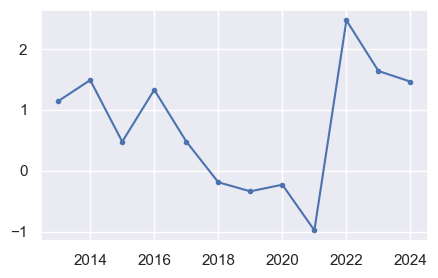

In [58]:
(PnL_net.groupby(PnL_net.index.map(lambda x:x.year)).mean()/PnL_net.groupby(PnL_net.index.map(lambda x:x.year)).std()*np.sqrt(252)).plot(marker='.')

## strat hybrid

In [52]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_oas_arbitrage(OAS_df, n_long=2, n_short=2, minimum_disloc=10, maximum_holding_days=60, bid_offer=0):
    """
    Backtest an OAS arbitrage strategy with a single active position at a time, correctly computing daily PnL.

    Parameters:
    OAS_df : DataFrame
        DataFrame containing dates in index and 9 TBA OAS values in columns.
    n_long : int
        Number of long positions to take (highest OAS TBAs).
    n_short : int
        Number of short positions to take (lowest OAS TBAs).
    minimum_disloc : float
        Minimum required OAS spread to enter a position.
    maximum_holding_days : int
        Maximum days to hold the position before force exiting.

    Returns:
    daily_pnl : DataFrame
        Daily profit and loss from the strategy.
    """
    dates = OAS_df.index
    daily_pnl = pd.Series(0.0, index=dates)
    
    # Track the current position
    position = None

    for i in range(1, len(dates)):  # Start from the second day (since we compare with yesterday)
        today = dates[i]
        yesterday = dates[i - 1]

        # 1. If a position is open, compute its daily PnL
        if position is not None:
            position["days_held"] += 1

            # Compute today's spread
            current_long_oas = np.mean(OAS_df.loc[today, position["long_columns"]])
            current_short_oas = np.mean(OAS_df.loc[today, position["short_columns"]])
            current_spread = current_long_oas - current_short_oas

            # Compute yesterday's spread
            prev_long_oas = np.mean(OAS_df.loc[yesterday, position["long_columns"]])
            prev_short_oas = np.mean(OAS_df.loc[yesterday, position["short_columns"]])
            prev_spread = prev_long_oas - prev_short_oas

            # Calculate PnL as the change in spread (minus transaction cost)
            pnl_today = -(current_spread - prev_spread)  # Transaction cost in OAS units
            daily_pnl[today] += pnl_today

            # 1.2 Check exit conditions
            if current_spread < minimum_disloc or position["days_held"] >= maximum_holding_days:
                position = None  # Close position
                daily_pnl[today] += -0.5*bid_offer

        # 2. If no position is open, decide whether to enter a new one
        if position is None:
            oas_values = OAS_df.loc[today].values
            sorted_idx = np.argsort(oas_values)  # Sort OAS values (ascending)

            # Get column names for selected TBAs
            long_columns = OAS_df.columns[sorted_idx[-n_long:]]  # Highest OAS
            short_columns = OAS_df.columns[sorted_idx[:n_short]]  # Lowest OAS

            long_oas_mean = np.mean(OAS_df.loc[today, long_columns])
            short_oas_mean = np.mean(OAS_df.loc[today, short_columns])
            spread = long_oas_mean - short_oas_mean

            # Enter a new position if spread is large enough
            if spread >= minimum_disloc:
                position = {
                    "entry_date": today,
                    "long_columns": long_columns,
                    "short_columns": short_columns,
                    "initial_spread": spread,
                    "days_held": 0
                }
                daily_pnl[today] += -0.5*bid_offer

    return daily_pnl


In [53]:
# Example data: Randomly generated OAS values for 9 TBAs over 500 days
np.random.seed(42)
OAS_df = OAS
dates = OAS_df.index

# Run the backtest
daily_pnl = backtest_oas_arbitrage(OAS_df, n_long=3, n_short=1, minimum_disloc=0,
                            maximum_holding_days=60, bid_offer=0.0)/100

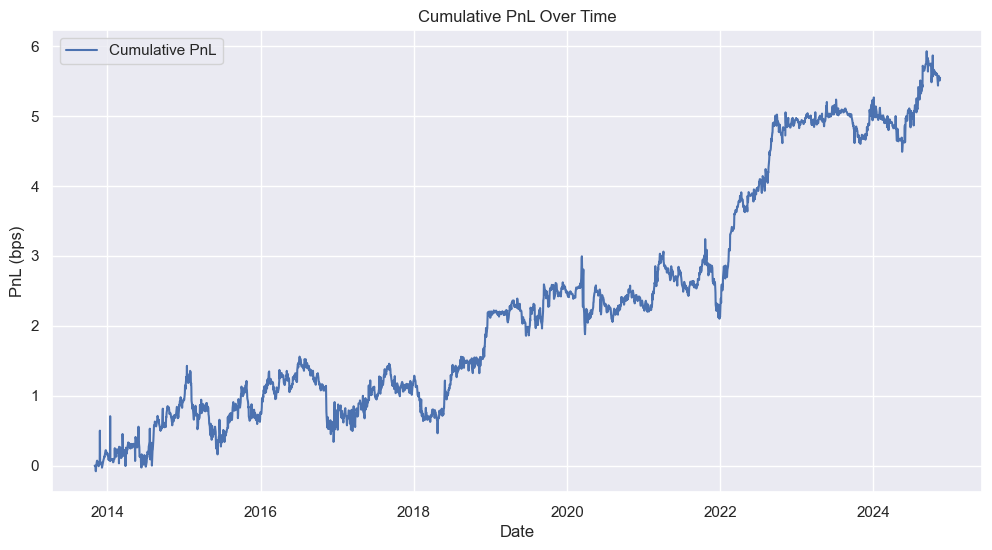

,Sharpe Ratio,Avg Yearly PnL,Yearly Volatility
0,0.448716,0.462231,0.82694


In [55]:

# Compute performance metrics
cum_pnl = daily_pnl.cumsum()
sharpe_ratio = daily_pnl.mean() / daily_pnl.std() * np.sqrt(252)  # Annualized
yearly_pnl = daily_pnl.resample('YE').sum()
yearly_vol = daily_pnl.resample('YE').sum()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(cum_pnl, label="Cumulative PnL", color='b')
plt.title("Cumulative PnL Over Time")
plt.xlabel("Date")
plt.ylabel("PnL (bps)")
plt.legend()
plt.grid(True)
plt.show()

# Display results
performance_df = pd.DataFrame({
    "Sharpe Ratio": [sharpe_ratio],
    "Avg Yearly PnL": [yearly_pnl.mean()],
    "Yearly Volatility": [yearly_vol.std()]
})

display(performance_df)

## PCA_strat

In [56]:
def backtest_pca_arbitrage(OAS_df, pca_components, pca_loadings, threshold=2, max_holding_days=60):
    """
    Backtest a PCA-based mean-reverting arbitrage strategy.

    Parameters:
    OAS_df : DataFrame
        DataFrame containing dates in index and 9 TBA OAS values in columns.
    pca_components : DataFrame
        PCA component time series over time.
    pca_loadings : np.array
        PCA eigenvector loadings for each TBA coupon.
    threshold : float
        Z-score threshold for entering trades.
    max_holding_days : int
        Maximum days to hold a position.

    Returns:
    daily_pnl : DataFrame
        Daily profit and loss from the strategy.
    """
    dates = OAS_df.index
    daily_pnl = pd.Series(0, index=dates)
    
    position = None  # Track if a position is open

    # Compute Z-score of PCA_1 over a rolling window
    pca_1 = pca_components["PCA_1"]
    rolling_mean = pca_1.rolling(window=50, min_periods=20).mean()
    rolling_std = pca_1.rolling(window=50, min_periods=20).std()
    z_scores = (pca_1 - rolling_mean) / rolling_std

    for i in range(1, len(dates)):  # Start from second day for spread computation
        today = dates[i]
        yesterday = dates[i - 1]

        # 1. If a position is open, compute PnL
        if position is not None:
            position["days_held"] += 1

            # Compute today's spread change
            current_long_oas = np.mean(OAS_df.loc[today, position["long_tba"]])
            current_short_oas = np.mean(OAS_df.loc[today, position["short_tba"]])
            current_spread = current_long_oas - current_short_oas

            prev_long_oas = np.mean(OAS_df.loc[yesterday, position["long_tba"]])
            prev_short_oas = np.mean(OAS_df.loc[yesterday, position["short_tba"]])
            prev_spread = prev_long_oas - prev_short_oas

            # Daily PnL as change in spread minus transaction cost
            pnl_today = -(current_spread - prev_spread) 
            daily_pnl[today] += pnl_today

            # Exit if PCA component mean-reverts or max holding period is reached
            if abs(z_scores[today]) < 0.5 or position["days_held"] >= max_holding_days:
                position = None

        # 2. If no position is open, decide whether to enter a new one
        if position is None:
            if z_scores[today] > threshold:  # Short high PCA TBA, long low PCA TBA
                long_tba = OAS_df.columns[np.argmin(pca_loadings[0])]  # Lowest loading TBA
                short_tba = OAS_df.columns[np.argmax(pca_loadings[0])]  # Highest loading TBA
                position = {
                    "entry_date": today,
                    "long_tba": long_tba,
                    "short_tba": short_tba,
                    "initial_z": z_scores[today],
                    "days_held": 0
                }

            elif z_scores[today] < -threshold:  # Long high PCA TBA, short low PCA TBA
                long_tba = OAS_df.columns[np.argmax(pca_loadings[0])]  # Highest loading TBA
                short_tba = OAS_df.columns[np.argmin(pca_loadings[0])]  # Lowest loading TBA
                position = {
                    "entry_date": today,
                    "long_tba": long_tba,
                    "short_tba": short_tba,
                    "initial_z": z_scores[today],
                    "days_held": 0
                }

    return daily_pnl

# Perform PCA on OAS data
pca = PCA(n_components=3)
OAS_mean = OAS_df.mean()
OAS_std = OAS_df.std()
OAS_normalized = (OAS_df - OAS_mean) / OAS_std
pca_transformed = pca.fit_transform(OAS_normalized)
pca_components = pd.DataFrame(pca_transformed, index=OAS_df.index, columns=[f"PCA_{i+1}" for i in range(3)])
pca_loadings = pca.components_

# Run PCA arbitrage backtest
daily_pnl_pca = backtest_pca_arbitrage(OAS_df, pca_components, pca_loadings, threshold=2, max_holding_days=60)

# Compute performance metrics
cum_pnl_pca = daily_pnl_pca.cumsum()
sharpe_ratio_pca = daily_pnl_pca.mean() / daily_pnl_pca.std() * np.sqrt(252)  # Annualized
yearly_pnl_pca = daily_pnl_pca.resample('Y').sum()
yearly_vol_pca = daily_pnl_pca.resample('Y').std()

# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cum_pnl_pca, label="Cumulative PnL (PCA Arbitrage)", color='b')
plt.title("Cumulative PnL Over Time (PCA Arbitrage)")
plt.xlabel("Date")
plt.ylabel("PnL (bps)")
plt.legend()
plt.grid(True)
plt.show()

# Display performance metrics
performance_df_pca = pd.DataFrame({
    "Sharpe Ratio": [sharpe_ratio_pca],
    "Avg Yearly PnL": [yearly_pnl_pca.mean()],
    "Yearly Volatility": [yearly_vol_pca.mean()]
})


display(performance_df_pca)


NameError: name 'PCA' is not defined